# SuStaIn tutorial -- October 2021

![SuStaIn](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-018-05892-0/MediaObjects/41467_2018_5892_Fig1_HTML.png?as=webp)
Image from [Young et al. Nat Comms 2018](https://doi.org/10.1038/s41467-018-05892-0).

In the present tutorial, we will go through the process of running SuStaIn, from data preprocessing to evaluating output, on a simulated dataset. The code below can serve as a code-base for your own SuStaIn analyses,

Note that we are using the Z-score SuStaIn for this demonstration, but versions of SuStaIn exist for binary and ordinal data as well.

## Installing SuStaIn and setting it up to run in a notebook

To get SuStaIn up and running first you need to install the package. I'm using Anaconda and had some conflicts with existing packagaes so I had to create a new environment. For me the whole set up process looked like this...

Step 1: Open up a terminal window and create a new environment "sustain_env" in anaconda that uses python 3.7 and activate the environment ready to install pySuStaIn.
```console
conda create --name sustain_tutorial_env python=3.7
conda activate sustain_tutorial_env
```

Step 2: Use the terminal to install necessary packages for running the notebook and pySuStaIn within the environment.
```console
conda install -y ipython jupyter matplotlib statsmodels numpy pandas scipy seaborn pip
pip install git+https://github.com/ucl-pond/pySuStaIn
```

Step 3: Use the terminal to run the notebook from inside the environment.
```console
jupyter notebook
```

Once you've got your environment running the general workflow will be to open a terminal window and navigate to the directory with the notebook in, activate the envirnoment, open a jupyter notebook inside and use the notebook to run your analyses, then use the terminal deactivate the environment once you've finished running analyses.
```console
conda activate sustain_tutorial_env
jupyter notebook
conda deactivate
```

In [4]:
import sys
sys.path.append('../') 

In [5]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection


In [6]:
# Load and view simulated tutorial data
# The data needs to be in the same directory as your notebook

data = pandas.read_csv('SimulatedData.csv')
data.head()

,RID,Diagnosis,Age,Headsize,Biomarker1,Biomarker2,Biomarker3,Biomarker4,Biomarker5
0,1,1,63.501953,0.920706,132.511729,180.698267,120.119201,159.200991,190.197486
1,2,1,61.240101,0.952784,154.500427,194.299318,179.148420,173.515194,237.807726
2,3,1,52.108876,1.061493,140.878957,170.449488,160.945261,163.988839,207.271331
3,4,1,65.989165,0.871652,146.361556,175.111234,164.769410,114.437784,184.657121
4,5,1,65.071640,1.147264,167.254806,203.470447,232.783278,212.857075,245.588402


It seems was have both patients (Diagnosis = 1) and controls (Diagnosis = 0) in this dataset. Let's quickly look how many we have of each

In [7]:
data.Diagnosis.value_counts()

1    467
0     33
Name: Diagnosis, dtype: int64

In [8]:
# store our biomarker labels as a variable
biomarkers = data.columns[4:]
print(biomarkers)

Index(['Biomarker1', 'Biomarker2', 'Biomarker3', 'Biomarker4', 'Biomarker5'], dtype='object')


# Normalize to control group

SuStaIn expects z-score cutoffs for each variable as input. Right now, our data is "raw" data. We want to convert this data to Z-scores, and it would be great to use the "Control" population as the reference for this z-score normalization. That way, we can interpret a Z score of 1 to mean 1 SD from the mean of a control population.

In this case, our biomarkers are "raw" values (let's pretend they are brain volumes"), and we also wany to adjust them for confounding effects of Age and Headsize.

The following section will convert our biomarkers into age- and headsize- adjusted Z scores, using the control subjects as a reference

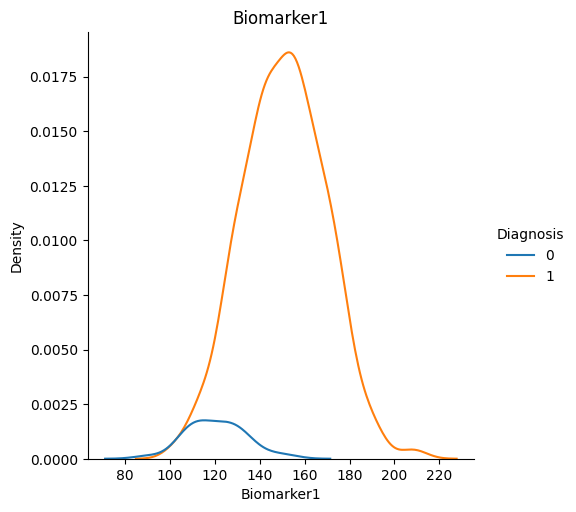

In [9]:
# first a quick look at the patient and control distribution for one of our biomarkers

biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='Diagnosis', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

<Axes: xlabel='Age', ylabel='Biomarker1'>

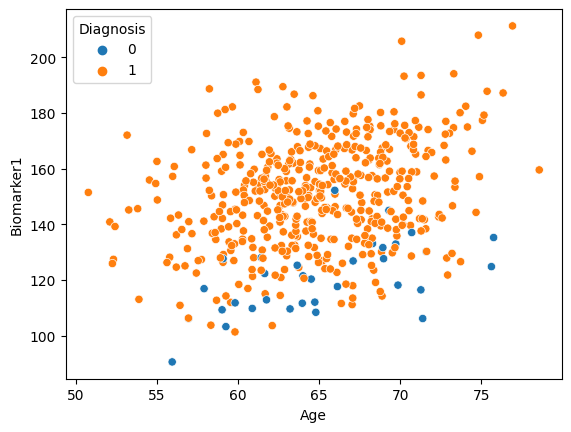

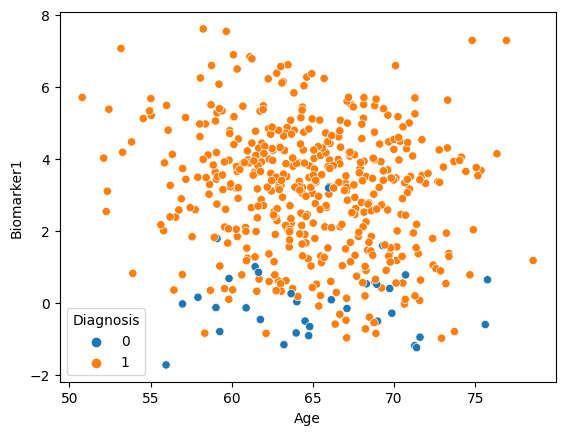

In [10]:
# now we perform the normalization

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

# for each biomarker
for biomarker in biomarkers:
    mod = smf.ols('%s ~ Age + Headsize'%biomarker,  # fit a model finding the effect of age and headsize on biomarker
                  data=data[data.Diagnosis==0] # fit this model *only* to individuals in the control group
                 ).fit() # fit model    
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['Age','Headsize',biomarker]]) 
    
    # calculate our zscore: observed - predicted / SD of the control group residuals
    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==0]))
    #print(np.std(w_score[data.Diagnosis==0]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score
    
    
plt.figure(0)
sns.scatterplot(x=data.Age,y=data.Biomarker1,hue=data.Diagnosis)
plt.figure(1)
sns.scatterplot(x=zdata.Age,y=zdata.Biomarker1,hue=zdata.Diagnosis)


Now that we've normalized the data, let's look at the new distribution and make sure it looks right

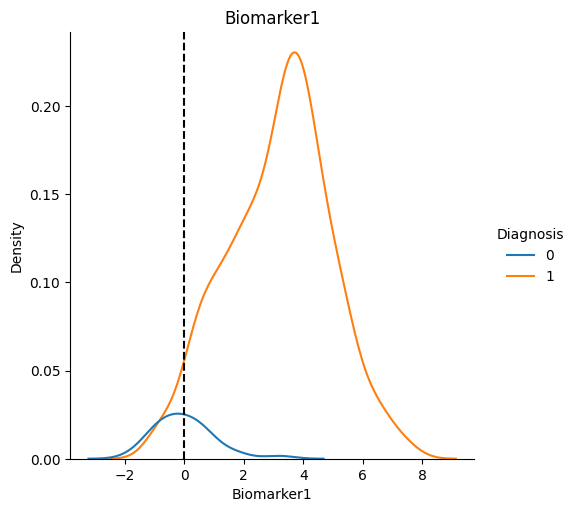

In [11]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='Diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

# Prepare SuStaIn inputs

Now that we've z-scored our data, let's start prepping the many SuStaIn inputs

In [12]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

In [13]:
print(Z_vals)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [14]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 10
N_S_max = 3
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# Run SuStaIn!

In [18]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [19]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /Users/linlin/Desktop/2023/pysustain copy/pySuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -4738.92231006323


MCMC Iteration: 100%|██████████| 10000/10000 [00:06<00:00, 1648.34it/s]


Failed to find pickle file: /Users/linlin/Desktop/2023/pysustain copy/pySuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4466.68227194]
Overall ML likelihood is [-4466.68227194]


MCMC Iteration: 100%|██████████| 10000/10000 [00:14<00:00, 710.14it/s]


Failed to find pickle file: /Users/linlin/Desktop/2023/pysustain copy/pySuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4460.84305901]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4461.10125826]
Overall ML likelihood is [-4460.84305901]


MCMC Iteration: 100%|██████████| 10000/10000 [00:19<00:00, 500.10it/s]


# Evaluate subtypes

Here, we'll plot the log likelihood across MCMC samples, across each subtype. This will give us at least a basic sense of what how many subtypes we should consider looking at

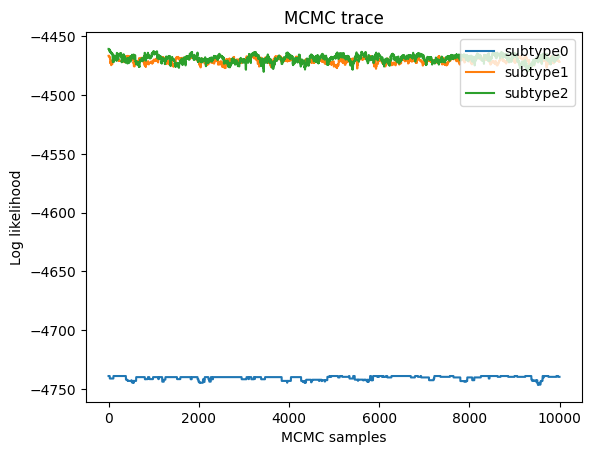

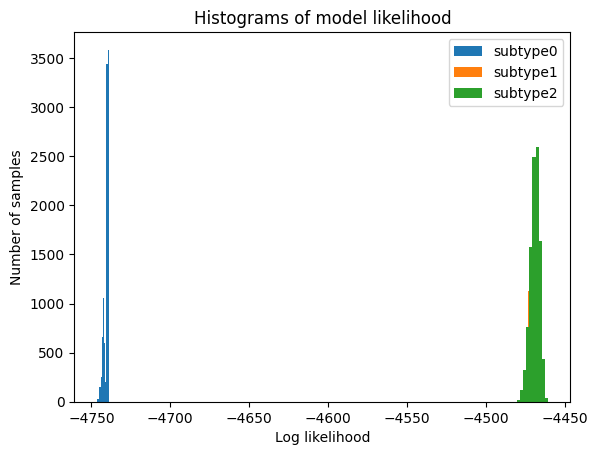

In [21]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')


It is very clear from this output that two subtypes fits the data better than one subtype, but adding a third subtype does not improve the model fit significantly. Let's move forward with the 2 subtype model.

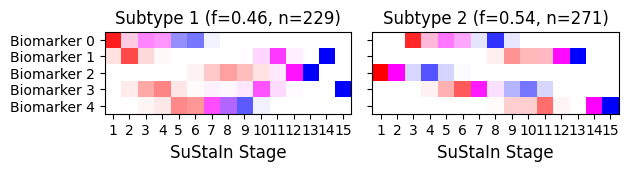

In [22]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))

It seems we have one subtype where Biomarker 3 becomes severe quickly, and a second where Biomarker 3 becomes abnormal far later, while Biomarker 5 occurs earlier.

# Subtype and stage individuals

In [23]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [24]:


# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

,RID,Diagnosis,Age,Headsize,Biomarker1,Biomarker2,Biomarker3,Biomarker4,Biomarker5,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,1,1,63.501953,0.920706,1.965731,1.672779,1.059005,2.483225,2.124796,1.0,0.963566,7.0,0.197461,0.036434
1,2,1,61.240101,0.952784,4.438108,4.592943,3.743060,3.142156,5.466800,1.0,0.943071,14.0,0.411005,0.056929
2,3,1,52.108876,1.061493,4.019363,2.466467,2.680370,2.722724,3.748348,1.0,0.984628,12.0,0.300120,0.015372
3,4,1,65.989165,0.871652,3.228515,0.280077,3.202390,0.449164,1.708204,0.0,0.919771,5.0,0.237044,0.919771
4,5,1,65.071640,1.147264,4.009545,2.927119,6.189362,4.064417,5.027144,1.0,0.674999,15.0,0.461393,0.325001


In [ ]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0

In [25]:
zdata.ml_subtype.value_counts()

0.0    267
1.0    233
Name: ml_subtype, dtype: int64

As a sanity check, let's make sure all the "controls" given were assigned to low stages by SuStaIn

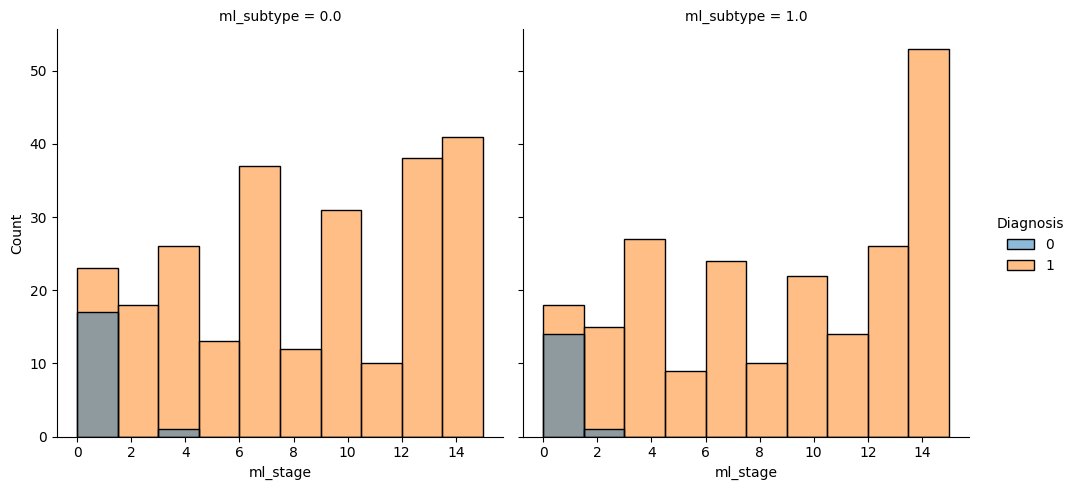

In [27]:
sns.displot(x='ml_stage',hue='Diagnosis',data=zdata,col='ml_subtype')

And now, let's plot the subtype probabilities over SuStaIn stages to make sure we don't have any crossover events

<i> what does crossover imply?: 

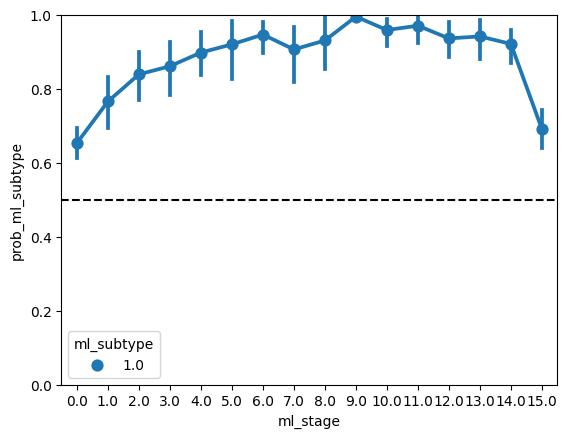

In [32]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata[zdata.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

# Evaluate relationships

One might want to view whether there are relationships between SuStaIn subtype and stage and other variables.

This step should probably be done after you run cross-validation (see below), but we'll do it here first to keep up the momentum

ValueError: x and y must have length at least 2.

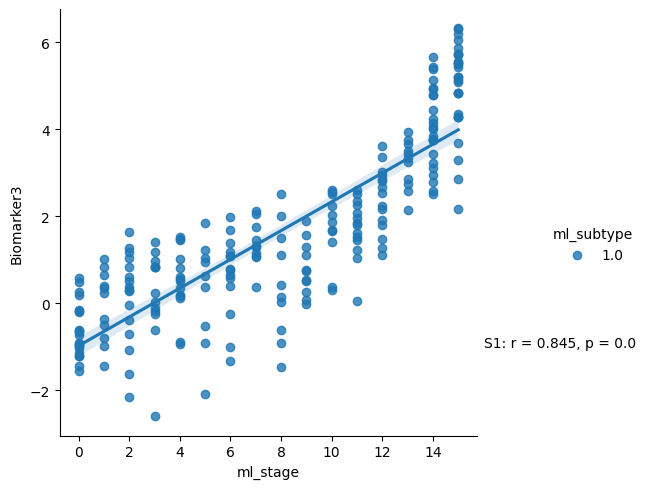

In [33]:
# Plotting relationship between a biomarker and SuStaIn stage across subtypes

var = 'Biomarker3'

# plot relationship
sns.lmplot(x='ml_stage',y=var,hue='ml_subtype',
          data = zdata[zdata.ml_subtype>0],
           #lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )

# get stats
for subtype in [1,2]:
    # get r and p value
    r,p = stats.pearsonr(x = zdata.loc[zdata.ml_subtype==subtype,var].values,
                         y = zdata.loc[zdata.ml_subtype==subtype,'ml_stage'].values)
    # add them to plot
    plt.text(16,0-subtype,'S%s: r = %s, p = %s'%(subtype,round(r,3),round(p,2)))

In [34]:
# we can also look at differences in each biomarker across subtypes

from scipy import stats
results = pandas.DataFrame(index=biomarkers)
for biomarker in biomarkers:
    t,p = stats.ttest_ind(zdata.loc[zdata.ml_subtype==0,biomarker],
                         zdata.loc[zdata.ml_subtype==1,biomarker],)
    results.loc[biomarker,'t'] = t
    results.loc[biomarker,'p'] = p
    
print(results)

                    t             p
Biomarker1  -4.127814  4.293368e-05
Biomarker2  -3.330935  9.298216e-04
Biomarker3  11.060345  1.409300e-25
Biomarker4   2.968537  3.136354e-03
Biomarker5 -10.167246  3.425122e-22


<Axes: >

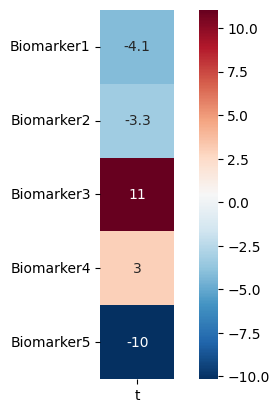

In [35]:
sns.heatmap(pandas.DataFrame(results['t']),square=True,annot=True,
           cmap='RdBu_r')

<Axes: xlabel='ml_subtype', ylabel='Biomarker3'>

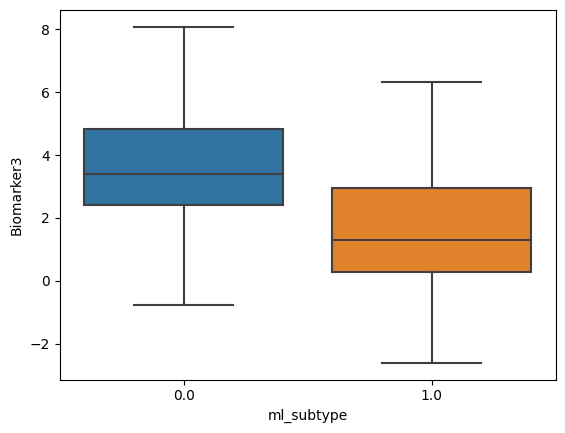

In [36]:
# plot an example variable:

var = 'Biomarker3'
sns.boxplot(x='ml_subtype',y=var,data=zdata)

# Cross-validation

Finally, it is often difficult to decide how many subtypes best fit your data. This question should ideally be evaluated using cross-validation. This way, the likelihood metrics are generated for data that the model has not yet seen. 

FYI we may not have nough time to run this full cross-validation during the workshop, but it's good for you to run it yourself. SuStaIn also support parallelized cross-validation!

In [37]:
# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds = 3

# generate stratified cross-validation training and test set splits
labels = zdata.Diagnosis.values
cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, shuffle=True)
cv_it = cv.split(zdata, labels)

# SuStaIn currently accepts ragged arrays, which will raise problems in the future.
# We'll have to update this in the future, but this will have to do for now
test_idxs = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs = np.array(test_idxs,dtype='object')

In [38]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -3127.1275088401303


MCMC Iteration: 100%|██████████| 10000/10000 [00:06<00:00, 1664.55it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2937.07184145]
Overall ML likelihood is [-2937.07184145]


MCMC Iteration: 100%|██████████| 10000/10000 [00:11<00:00, 851.67it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2931.3087227]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2932.95736635]
Overall ML likelihood is [-2931.3087227]


Folds:  33%|███▎      | 1/3 [03:31<07:02, 211.39s/it]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -3170.3058853801194


MCMC Iteration: 100%|██████████| 10000/10000 [00:05<00:00, 1714.65it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2991.82058955]
Overall ML likelihood is [-2991.82058955]


MCMC Iteration: 100%|██████████| 10000/10000 [00:13<00:00, 755.88it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2986.04200153]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2987.48664754]
Overall ML likelihood is [-2986.04200153]


Folds:  67%|██████▋   | 2/3 [07:03<03:31, 211.77s/it]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -3169.350675168471


MCMC Iteration: 100%|██████████| 10000/10000 [00:05<00:00, 1774.48it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2997.34841835]
Overall ML likelihood is [-2997.34841835]


MCMC Iteration: 100%|██████████| 10000/10000 [00:13<00:00, 766.25it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2992.67304263]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2994.13099583]
Overall ML likelihood is [-2992.67304263]


Folds: 100%|██████████| 3/3 [10:38<00:00, 212.96s/it]

Average test set log-likelihood for each subtype model: [-1588.92818495 -1496.50312847 -1497.46787992]
CVIC for each subtype model: [9482.7247813  8956.40081744 8960.07388282]


# Choosing the optimal number of subtypes
The optimal number of subtypes is chosen using the CVIC, shown below. The CVIC is an information criterion (like the AIC/BIC/WAIC) that balances model complexity with model accuracy, with a lower CVIC indicating a better balance between the two. Generally speaking, the model with the lowest CVIC is the best. However, you do sometimes get a very small improvement (less than ~6) in the CVIC with a more complex model, in which case I would tend to favour the less complex (i.e. fewer subtypes) model.

Another useful metric to look at is the log-likelihood of each subtypes model on the test set, also shown below. A better model should show a consistent improvement in the test set log-likelihood across folds.

CVIC for each subtype model: [9482.7247813  8956.40081744 8960.07388282]
Average test set log-likelihood for each subtype model: [-1588.92818495 -1496.50312847 -1497.46787992]


Text(0.5, 1.0, 'Test set log-likelihood across folds')

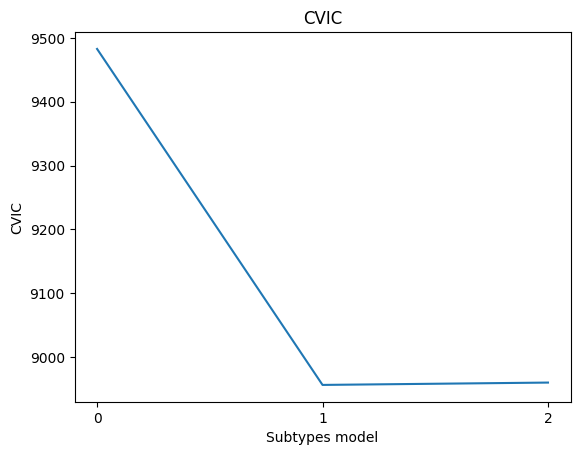

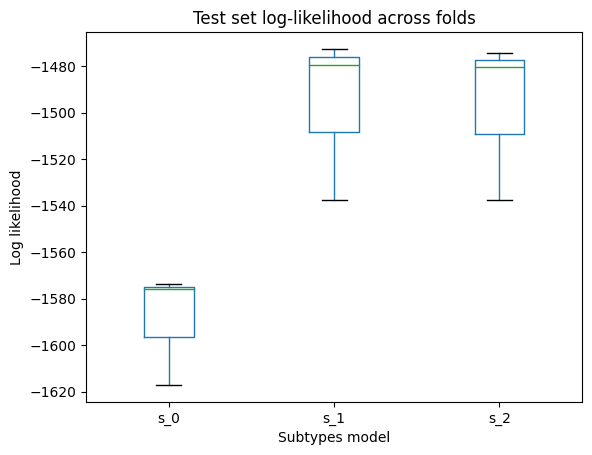

In [39]:
# go through each subtypes model and plot the log-likelihood on the test set and the CVIC
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

plt.figure(0)    
plt.plot(np.arange(N_S_max,dtype=int),CVIC)
plt.xticks(np.arange(N_S_max,dtype=int))
plt.ylabel('CVIC')  
plt.xlabel('Subtypes model') 
plt.title('CVIC')

plt.figure(1)
df_loglike = pandas.DataFrame(data = loglike_matrix, columns = ["s_" + str(i) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(grid=False)
plt.ylabel('Log likelihood')  
plt.xlabel('Subtypes model') 
plt.title('Test set log-likelihood across folds')

Another useful output of the cross-validation that you can look at are positional variance diagrams averaged across cross-validation folds. These give you an idea of the variability in the progression patterns across different training datasets.

/Users/linlin/Desktop/2023/pysustain copy/pySuStaIn/notebooks/../pySuStaIn/ZscoreSustain.py:505: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(
/Users/linlin/Desktop/2023/pysustain copy/pySuStaIn/notebooks/../pySuStaIn/AbstractSustain.py:523: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


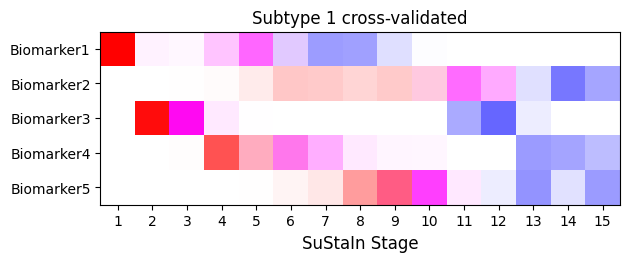

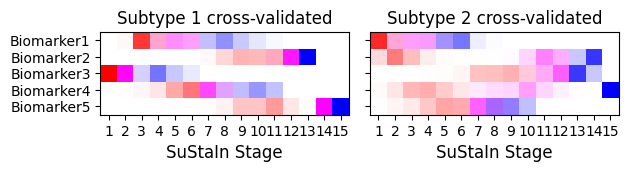

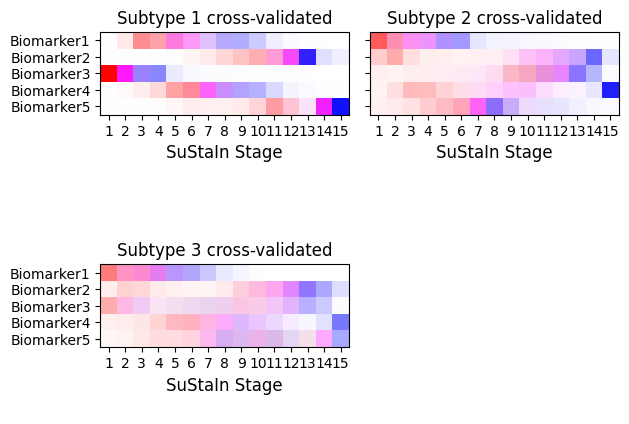

In [40]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max):
    sustain_input.combine_cross_validated_sequences(i+1, N_folds)

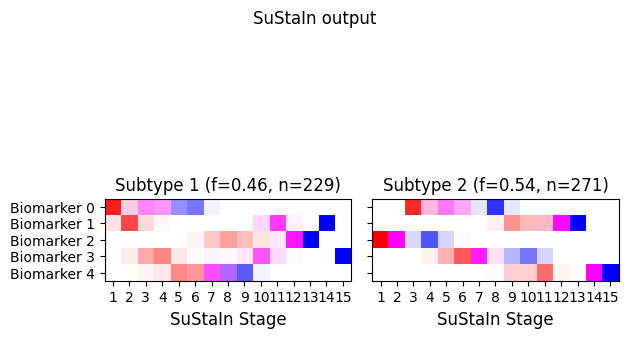

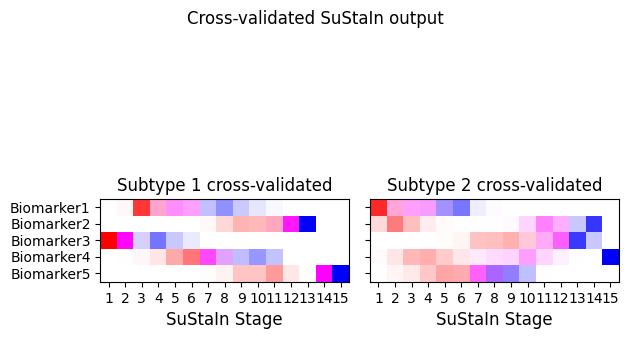

In [41]:
N_S_selected = 2

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))
_ = plt.suptitle('SuStaIn output')

sustain_input.combine_cross_validated_sequences(N_S_selected, N_folds)
_ = plt.suptitle('Cross-validated SuStaIn output')